**Exceptions** are errors encountered while running a program and they differ from **syntax errors**, which are errors that the compiler encounters when trying to compile your program.

Let's give an example:

In [1]:
if 1 == 3):
    return True

SyntaxError: unmatched ')' (3816039867.py, line 1)

Here we have a syntax error and this actually occurre before anything was compiled and by Python's design it gives a good idea of where the error occurs. Let's prove that this happens before the program runs:

In [2]:
print("Starting!")
if 1 == 3):
    return True

SyntaxError: unmatched ')' (372807551.py, line 2)

As we can see, it never got that `print()` statement because, again, Python tries to compile everything before it actually runs it. This is different than a normal **exception** in which the program is actually running when the error is encountered. Let's prove it:

In [3]:
print("Starting!")
a = 5 / 0

Starting!


ZeroDivisionError: division by zero

Now we got the `print()` statement.

`ZeroDivisionError` is one of the built-in exception class that Python provides and it's a subclass of the main `Exception` class (even all additional built-in exceptions that we'll see are):

In [4]:
issubclass(ZeroDivisionError, Exception)

True

## How to handle Exceptions

We can handle exceptions with **try-except** block where afte the `try` kewyword we put our risky code and then after the `except` we put the code to run if the exception was catch:

In [5]:
try:
    5/0
except:
    print("An exception occurred!")

An exception occurred!


In this case we didn't specify any specific exception to catch. And this is not recommended: we don's want to have blank `execpt` statements, but we want to **be more specific about what you're trying to catch**. So, let's modify thhe example:

In [6]:
try:
    5/0
except ZeroDivisionError:
    print("You tried to divide by 0!")

You tried to divide by 0!


It's good to be specific about the types of errors you catch because if an exception is raised deeper within your program or in a dependent library (something you hadn't anticipated) you want that exception to continue propagating. You should only catch specific errors that you intend to handle. In fact, if we try to cast a string to an integer, that's not going to be caught by the `ZeroDivisionError`exception:

In [7]:
try:
    5/1
    int("a")
except ZeroDivisionError:
    print("You tried to divide by 0!")

ValueError: invalid literal for int() with base 10: 'a'

As we can see, this exception gets raised as a `ValueError`. If this is something that we want to handle we can modify our `except` clause to also account for that:

In [8]:
try:
    5/1
    int("a")
except ValueError as err:
    print(f"You didn't give me an integer: {err}")

You didn't give me an integer: invalid literal for int() with base 10: 'a'


Note that the syntax `except ValueError as err:` allows us to store the `ValueError` object into the variable `err`, which means we can do something with it. In our case, we used it to give back a little bit more custom feedback message (that's the actual message provided within the `ValueError`).

This is a general pattern code to follow for anything that is a non-trivial exception.

Say we wanted to make a script that acted as a simple calculator. We would like to do some type of continuous loop that will ask for user input do some kind of calculation and then return the result:

In this code there are few areas where we could potentially run into an issue. The first is going to be receiving user input because, while the script is waiting, the user can decide to hit ctrl+c to stop the script which would raise a `KeyboardInterrupt` exception:


What `else` does is it runs an additional statement if an exception is not caught. Now let's define `do_cal` function:

In [9]:
def do_calc(calc_expr):
    left, op, right = calc_expr.split()
    left = int(left)
    right = int(right)
    if op == "+":
        return left + right
    elif op == "-":
        return left - right
    elif op == "*":
        return left * right
    elif op == "/":
        return left / right

Of course this method is pretty naive because if you have an expression like `5* 7` it returns a `ValueError`:

In [10]:
left, op, right = "5* 7".split()

ValueError: not enough values to unpack (expected 3, got 2)

So, we can wrap this piece of code into a try-except clause:

In [11]:
class UserError(Exception):
    pass

def do_calc(calc_expr):
    try:
        left, op, right = calc_expr.split()
    except ValueError:
        raise UserError("Make sure there is one space between each element.")
    left = int(left)
    right = int(right)
    if op == "+":
        return left + right
    elif op == "-":
        return left - right
    elif op == "*":
        return left * right
    elif op == "/":
        return left / right

Here we are raising a custom `UserError`, which means we are creating an exception and passing it up to whataver called us or whatever is above us in the call chain. In our example what's above us is this piece of code `result = do_calc(to_calc)`. So, we have a new exception and we need to handle it:

Another potential issue we can run into is the conversion of `left` and `right` value to `int`. What if someone gives a value that can't be converted into an integer? That's another kind of exeption that we could potentially encounter:

In [14]:
class UserError(Exception):
    pass

class UserValueError(UserError):
    def __init__(self, bad_val):
        self.message = f"'{bad_val}' can't be converted to an integer"
        

def do_calc(calc_expr):
    try:
        left, op, right = calc_expr.split()
    except ValueError:
        raise UserError("Make sure there is one space between each element.")
    
    try:
        left = int(left)
    except ValueError as err:
        raise UserValueError(left)
    
    try:
        right = int(right)
    except ValueError as err:
        raise UserValueError(right)

    if op == "+":
        return left + right
    elif op == "-":
        return left - right
    elif op == "*":
        return left * right
    elif op == "/":
        return left / right

Until now we are not using the `err` variable representing the `ValueError`. If you want to give a bit more context as to where the error coming from when you're using custom errors, you can say: `raise UserValueError(left) from err`.

One last thing to handle in our function is what if someone tries to pass an operation that isn't plit, minus, multiply, or divide? Let's fix it:

In [15]:
class UserError(Exception):
    pass

class UserValueError(UserError):
    def __init__(self, bad_val):
        self.message = f"'{bad_val}' can't be converted to an integer."
        

def do_calc(calc_expr):
    try:
        left, op, right = calc_expr.split()
    except ValueError:
        raise UserError("Make sure there is one space between each element.")
    
    try:
        left = int(left)
    except ValueError as err:
        raise UserValueError(left) from err
    
    try:
        right = int(right)
    except ValueError as err:
        raise UserValueError(right) from err

    if op == "+":
        return left + right
    elif op == "-":
        return left - right
    elif op == "*":
        return left * right
    elif op == "/":
        return left / right
    else:
        UserError(f"{op} is not a supported operation.")

As before, we add this new `UserValueError` to our main code:

The strange part is that the input `a + 6` raised a `UserError` instead of the expected `UserValueError`. We anticipated a specific message from `UserValueError`, but a different behavior occurred. This happened because of how Python handles exceptions: it processes them from top to bottom. Although `UserValueError` is the more appropriate exception, it inherits from `UserError`, which appeared first in our code, so `UserError` was triggered instead.

The rule is: when you have exceptions that inherit from others or are more specific, you should list them before the more general ones. So, let's adjust the order of the exceptions accordingly:

## raise syntax

`raise` is useful when you don't want to modify the chain where an exception is being called from, so you just want to make sure that you catch the exception possibly do something before you raise the exception back up, but raise will just raise whatever exception it encountered straight back up the call chain:

If we give as input `a + 6`, we got:

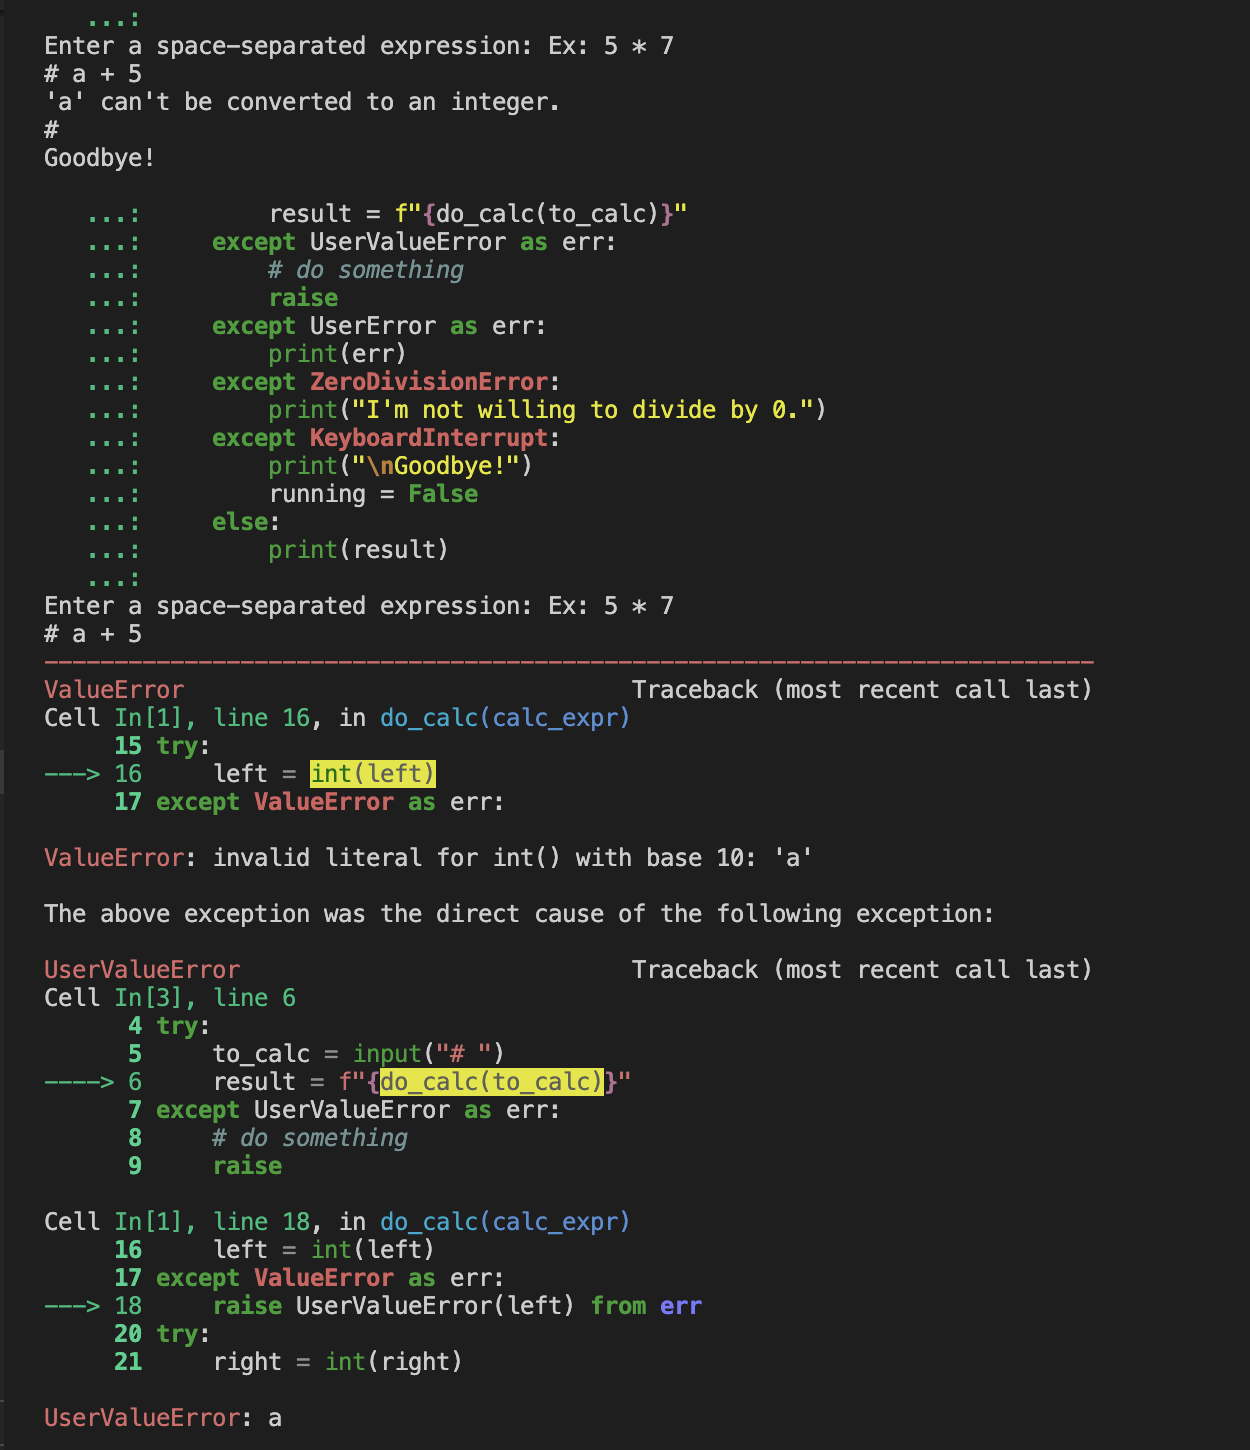

## `finally`

Code in `finally` block is going to run every single time, no matter what happens: